# Support Vector Machines

*** Scores for grid search are already included in notes, clearly marked if you don't want to rerun

In [135]:
import os

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from yellowbrick.classifier import ClassificationReport

In [136]:
from yellowbrick.model_selection import FeatureImportances

In [137]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

In [138]:
import matplotlib
import matplotlib.pyplot as plt

In [139]:
import pandas as pd
import numpy as np

In [140]:
import warnings
warnings.filterwarnings('ignore')

In [141]:
from sklearn.compose import make_column_selector
categorical = make_column_selector(dtype_include=np.object)
numeric = make_column_selector(dtype_include=np.int64)
numeric2 = make_column_selector(dtype_include=np.float64)

In [142]:
df = pd.read_csv('s3://covidstatedata/final_dataset.csv')
pd.set_option("display.max_columns", None)

df1 = df.dropna()

In [143]:
X = df1[['% Vaccinated', '80th Percentile Income', '20th Percentile Income', 
        'Income Ratio', 'Median Household Income', 'Population', 'Life Expectancy', #LSVCworks better without life exp
        '% Less Than 18 Years of Age', '% 65 and Over', '% Black', '% American Indian & Alaska Native', 
        '% Asian', '% Native Hawaiian/Other Pacific Islander', '% Hispanic', '% Non-Hispanic White', 
        '% Female', '% Rural', 'Series_Complete_Pop_Pct', 'Series_Complete_12PlusPop_Pct', 'Series_Complete_18PlusPop_Pct',
        'Series_Complete_65PlusPop_Pct', 'Completeness_pct', 
        '# Black', '# American Indian & Alaska Native', '# Asian', '# Native Hawaiian/Other Pacific Islander', 
         '# Hispanic', '# Non-Hispanic White', '# Rural', 'Series_Complete_Yes', 'Series_Complete_12Plus', 
         'Series_Complete_18Plus', 'Series_Complete_65Plus']]



y = df1['Dem0_Rep1']

In [144]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport
def score_model_test(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    #setup pipeline for onehotcoder and scalar
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', MinMaxScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
    ('estimator', estimator)
])

    
    
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, random_state=11)
    
    model.fit(X_train, y_train)  
    
    
    # Instantiate the classification model and visualizer

    expected  = y_test
    predicted = model.predict(X_test)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("F1 SCORE {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))
    print(model.score(X_test, y_test))
    
    
def visualize_model_split(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', MinMaxScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer, can change for any visualizer in Yellow Brick
    visualizer = ClassificationReport(
        model, classes=['D', 'R'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, random_state=11)
    
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.show()  

In [145]:
#Change this and above scalers for other models

models = [
    LinearSVC(random_state=41), 
]

F1 SCORE LinearSVC: 0.9718172983479104
0.9524590163934427


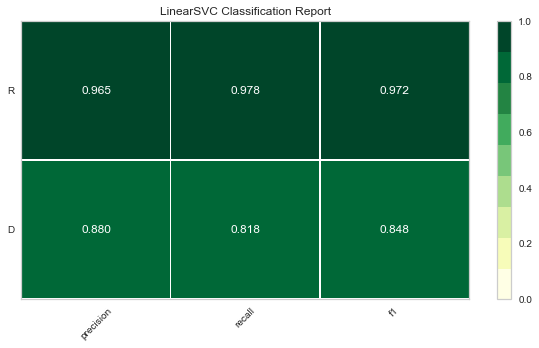

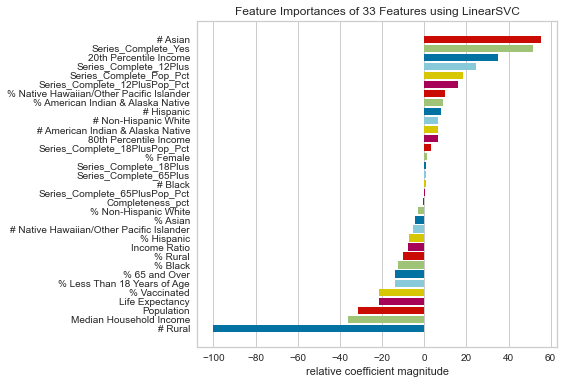

In [146]:
for model in models:
    score_model_test(X, y, model)
    visualize_model_split(X, y, model)
    viz = FeatureImportances(models[0])
    viz.fit(X, y)
    viz.show()

# Examine Gridsearch for SVM

In [147]:
from sklearn import preprocessing
X = preprocessing.scale(X)

In [148]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, random_state=11)

In [149]:
from sklearn.model_selection import GridSearchCV

*** Gridsearch below

In [19]:
param_grid={'C':[0.1,1,10,100,1000], 'kernel':['rbf', 'poly', 'sigmoid', 'linear'], 'degree':[1, 2, 3]}
grid = GridSearchCV(SVC(), param_grid)
grid.fit(X_train, y_train)

#{'C': 1, 'degree': 1, 'kernel': 'rbf'}
#0.940983606557377

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'degree': [1, 2, 3],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']})

In [20]:
print(grid.best_params_)
print(grid.score(X_test, y_test))

{'C': 1, 'degree': 1, 'kernel': 'rbf'}
0.940983606557377


# Gridsearch on Final Features for Logistic Regression

This is to see if things change dramatically if we limit the number of features

In [28]:
#Feature Importance on Logistic Regression selects these features, lets quickly compare. 
X = df1[[
              '% Less Than 18 Years of Age',
              '% 65 and Over', 
              '% Black',  
              '% Asian',  
              '% Non-Hispanic White', 
              '% Female', 
              '% Rural', 
              'Series_Complete_Pop_Pct', 
              'Series_Complete_12PlusPop_Pct', 
              'Series_Complete_18PlusPop_Pct',
              'Series_Complete_65PlusPop_Pct', 
              'Completeness_pct', 
         
          ]]

y = df1['Dem0_Rep1']

In [29]:
X = preprocessing.scale(X)

In [30]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, random_state=11)

In [24]:
param_grid={'C':[0.1,1,10,100,1000], 'kernel':['rbf', 'poly', 'sigmoid', 'linear'], 'degree':[1, 2]}
grid = GridSearchCV(SVC(), param_grid)
grid.fit(X_train, y_train)


#results
#{'C': 1, 'degree': 1, 'kernel': 'rbf'}
#0.9393442622950819

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'degree': [1, 2],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']})

In [25]:
print(grid.best_params_)
print(grid.score(X_test, y_test))

{'C': 1, 'degree': 1, 'kernel': 'rbf'}
0.9393442622950819


C and Kernel do not change, 1 and rbf respectively

# Comparing LinearSVM to Radial Basis Function (rbf)

In [150]:
X = df1[['% Vaccinated', '80th Percentile Income', '20th Percentile Income', 
        'Income Ratio', 'Median Household Income', 'Population', 'Life Expectancy', #LSVCworks better without life exp
        '% Less Than 18 Years of Age', '% 65 and Over', '% Black', '% American Indian & Alaska Native', 
        '% Asian', '% Native Hawaiian/Other Pacific Islander', '% Hispanic', '% Non-Hispanic White', 
        '% Female', '% Rural', 'Series_Complete_Pop_Pct', 'Series_Complete_12PlusPop_Pct', 'Series_Complete_18PlusPop_Pct',
        'Series_Complete_65PlusPop_Pct', 'Completeness_pct', 
        '# Black', '# American Indian & Alaska Native', '# Asian', '# Native Hawaiian/Other Pacific Islander', 
         '# Hispanic', '# Non-Hispanic White', '# Rural', 'Series_Complete_Yes', 'Series_Complete_12Plus', 
         'Series_Complete_18Plus', 'Series_Complete_65Plus']]



y = df1['Dem0_Rep1']

In [151]:
models = [
    LinearSVC(random_state=41),
    SVC(random_state=41),
    SVC(kernel= 'rbf', random_state=41, C=1), 
    ]

F1 SCORE LinearSVC: 0.9718172983479104
0.9524590163934427


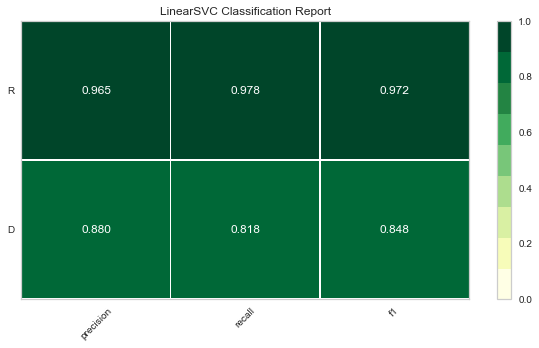

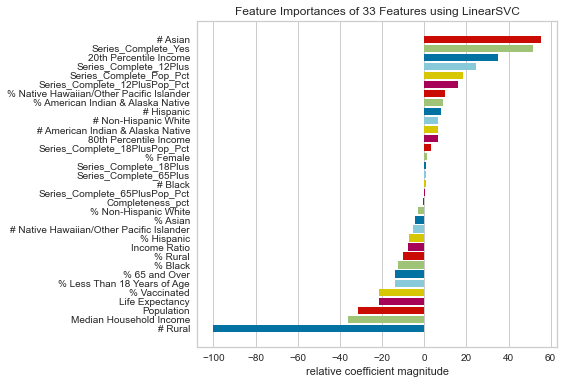

F1 SCORE SVC: 0.9587727708533077
0.9295081967213115


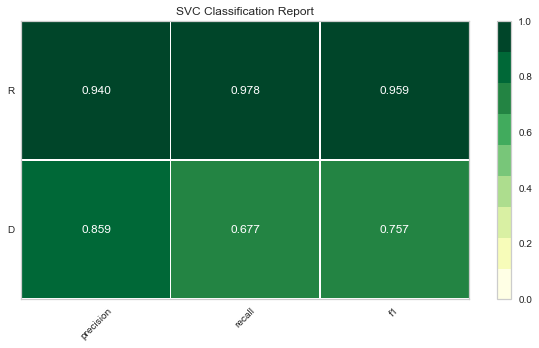

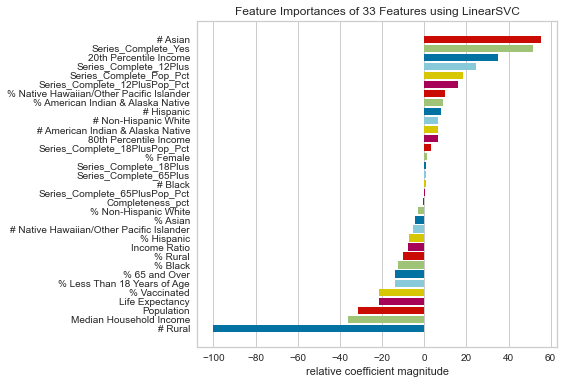

F1 SCORE SVC: 0.9587727708533077
0.9295081967213115


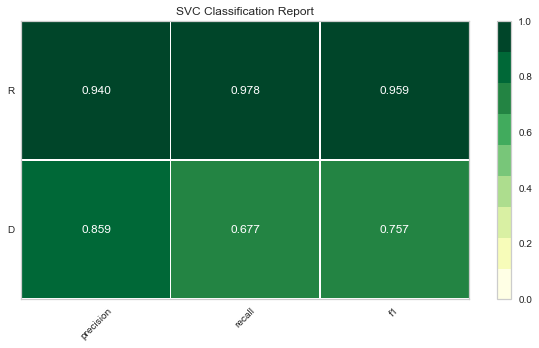

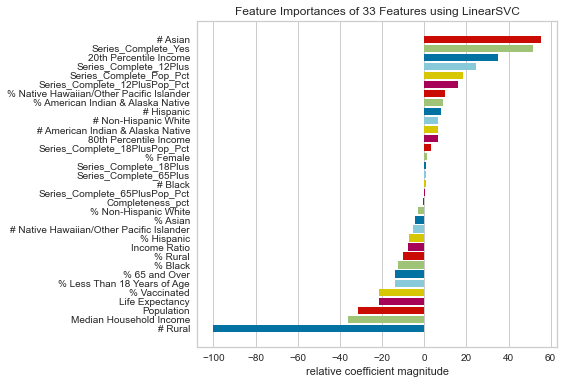

In [152]:
for model in models:
    score_model_test(X, y, model)
    visualize_model_split(X, y, model)
    viz = FeatureImportances(models[0])
    viz.fit(X, y)
    viz.show()

While the gridsearch says that rbf is ideal, I am primarily utilizing Recall for D to make my decision regarding tuning. Since the Linear SVC performs better, I am going to stick with LSVC to do feature reduction

# Co-Linear Feature Analysis

Lets compare when % or # are removed for features that have both transformations

In [153]:
Xpercent = df1[['% Vaccinated', '80th Percentile Income', '20th Percentile Income', 
        'Income Ratio', 'Life Expectancy', 'Median Household Income', 'Population', 
        '% Less Than 18 Years of Age', '% 65 and Over', '% Black', '% American Indian & Alaska Native', 
        '% Asian', '% Native Hawaiian/Other Pacific Islander', '% Hispanic', '% Non-Hispanic White', 
        '% Female', '% Rural', 'Series_Complete_Pop_Pct', 'Series_Complete_12PlusPop_Pct', 'Series_Complete_18PlusPop_Pct',
        'Series_Complete_65PlusPop_Pct', 'Completeness_pct', 
         
          ]]

ypercent = df1['Dem0_Rep1']

Xcount = df1[['% Vaccinated', '80th Percentile Income', '20th Percentile Income', 
        'Income Ratio', 'Life Expectancy', 'Median Household Income', 'Population', 
        '% Less Than 18 Years of Age', '% 65 and Over',  
        '% Female', 'Series_Complete_Pop_Pct',
        '# Black', '# American Indian & Alaska Native', '# Asian', '# Native Hawaiian/Other Pacific Islander', 
         '# Hispanic', '# Non-Hispanic White', '# Rural', 'Series_Complete_Yes', 'Series_Complete_12Plus', 
         'Series_Complete_18Plus', 'Series_Complete_65Plus']]

ycount = df1['Dem0_Rep1']


In [154]:
models = [
    LinearSVC(random_state=41), 
    ]

F1 SCORE LinearSVC: 0.9718172983479104
0.9524590163934427


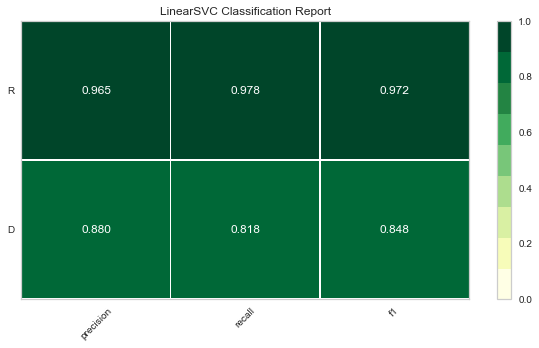

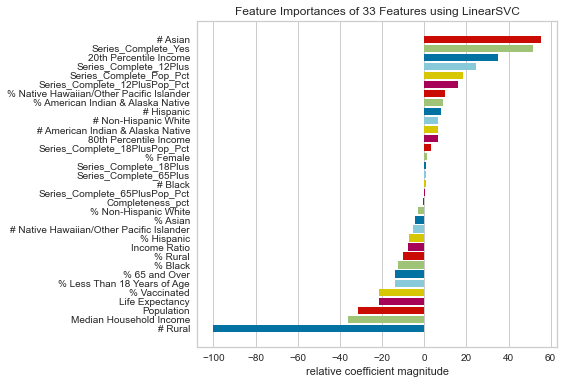

In [155]:
for model in models:
    score_model_test(X, y, model)
    visualize_model_split(X, y, model)
    viz = FeatureImportances(models[0])
    viz.fit(X, y)
    viz.show()

F1 SCORE LinearSVC: 0.9729206963249517
0.9540983606557377


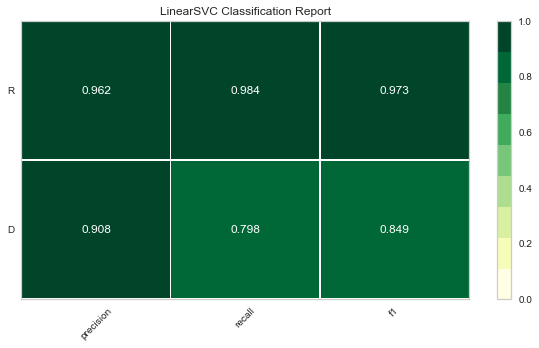

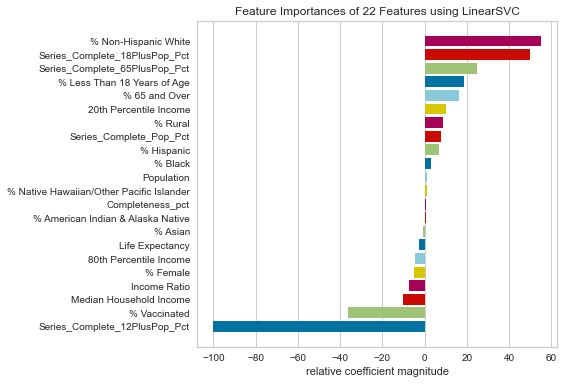

In [156]:
for model in models:
    score_model_test(Xpercent, ypercent, model)
    visualize_model_split(Xpercent, ypercent, model)
    viz = FeatureImportances(models[0])
    viz.fit(Xpercent, ypercent)
    viz.show()

F1 SCORE LinearSVC: 0.9472693032015066
0.9081967213114754


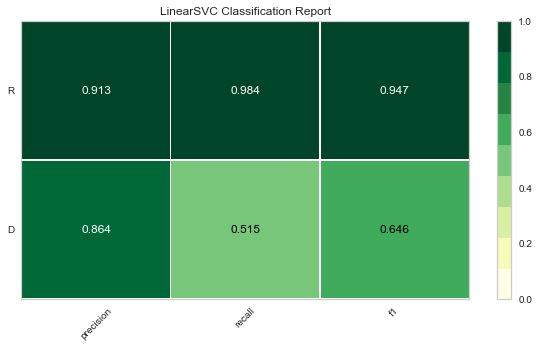

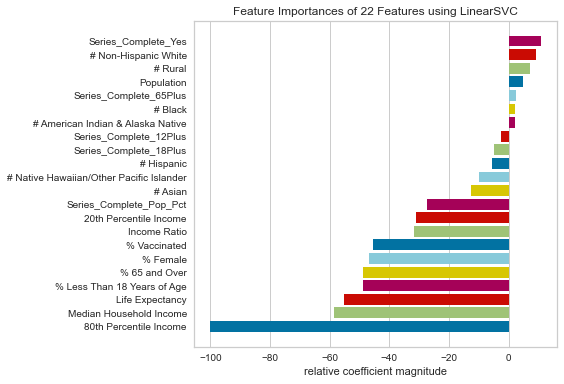

In [157]:
for model in models:
    score_model_test(Xcount, ycount, model)
    visualize_model_split(Xcount, ycount, model)
    viz = FeatureImportances(models[0])
    viz.fit(Xcount, ycount)
    viz.show()

While recall for D drops .02 when the integer colinear features are removed, percision and R scores improve. Since the change in recall is rather small yet we have eliminated many redundant features, I will continue with recursive feature reduction on the % data. 

In [158]:
X = df1[[
         '% Vaccinated', 
         '80th Percentile Income', 
         '20th Percentile Income',  
         'Income Ratio', 
         'Life Expectancy', 
         'Median Household Income', 
         'Population', 
         '% Less Than 18 Years of Age', 
         '% 65 and Over',  
         '% Black', 
         '% American Indian & Alaska Native', 
         '% Asian', 
         '% Native Hawaiian/Other Pacific Islander',
         '% Hispanic', 
         '% Non-Hispanic White', 
         '% Female', 
         '% Rural', 
         'Series_Complete_Pop_Pct', 
         'Series_Complete_12PlusPop_Pct',
         'Series_Complete_18PlusPop_Pct',
         'Series_Complete_65PlusPop_Pct', 
         'Completeness_pct', 
         
          ]]

y = df1['Dem0_Rep1']

F1 SCORE LinearSVC: 0.9729206963249517
0.9540983606557377


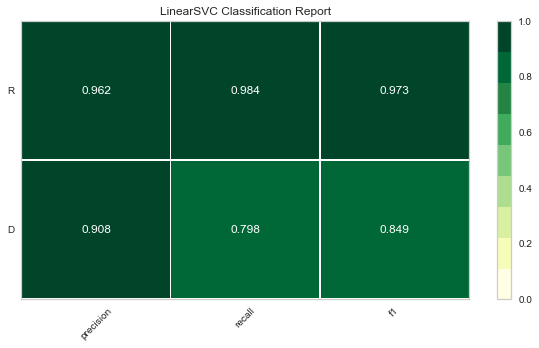

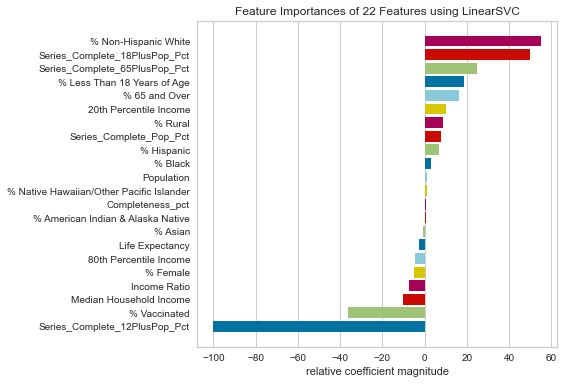

In [159]:
for model in models:
    score_model_test(X, y, model)
    visualize_model_split(X, y, model)
    viz = FeatureImportances(models[0])
    viz.fit(X, y)
    viz.show()

In [160]:
X = df1[[
         #'% Vaccinated', 
         #'80th Percentile Income', 
         #'20th Percentile Income',  
         #'Income Ratio', 
         #'Life Expectancy', 
         #'Median Household Income', 
         #'Population', 
         #'% Less Than 18 Years of Age', 
         #'% 65 and Over',  
         '% Black', 
         '% American Indian & Alaska Native', 
         '% Asian', 
         '% Native Hawaiian/Other Pacific Islander',
         '% Hispanic', 
         '% Non-Hispanic White', 
         '% Female', 
         '% Rural', 
         'Series_Complete_Pop_Pct', 
         'Series_Complete_12PlusPop_Pct',
         'Series_Complete_18PlusPop_Pct',
         'Series_Complete_65PlusPop_Pct', 
         'Completeness_pct', 
         
          ]]

y = df1['Dem0_Rep1']

F1 SCORE LinearSVC: 0.9655172413793104
0.940983606557377


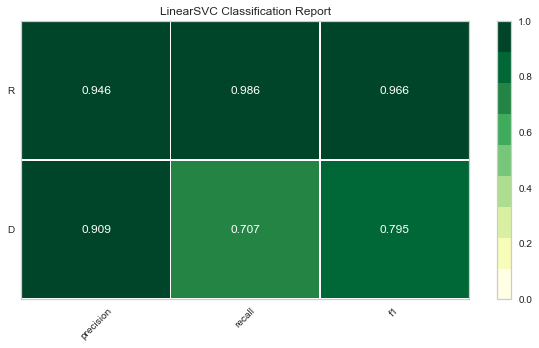

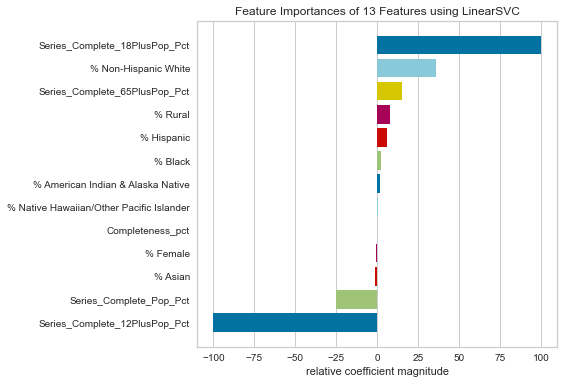

In [161]:
for model in models:
    score_model_test(X, y, model)
    visualize_model_split(X, y, model)
    viz = FeatureImportances(models[0])
    viz.fit(X, y)
    viz.show()

In [162]:
X = df1[[
         '% Vaccinated', 
         '80th Percentile Income', 
         '20th Percentile Income',  
         'Income Ratio', 
         'Life Expectancy', 
         'Median Household Income', 
         'Population', 
         '% Less Than 18 Years of Age', 
         '% 65 and Over',  
         #'% Black', 
         #'% American Indian & Alaska Native', 
         #'% Asian', 
         #'% Native Hawaiian/Other Pacific Islander',
         #'% Hispanic', 
         #'% Non-Hispanic White', 
         #'% Female', 
         #'% Rural', 
         'Series_Complete_Pop_Pct', 
         'Series_Complete_12PlusPop_Pct',
         'Series_Complete_18PlusPop_Pct',
         'Series_Complete_65PlusPop_Pct', 
         'Completeness_pct', 
         
          ]]

y = df1['Dem0_Rep1']

F1 SCORE LinearSVC: 0.95004712535344
0.9131147540983606


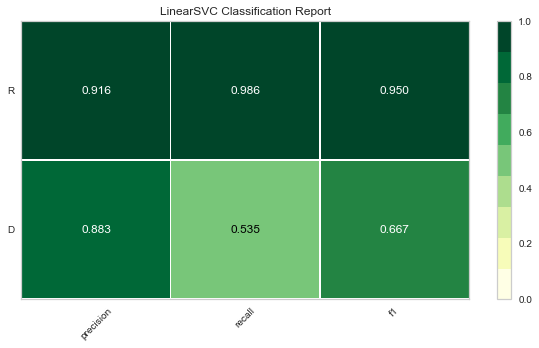

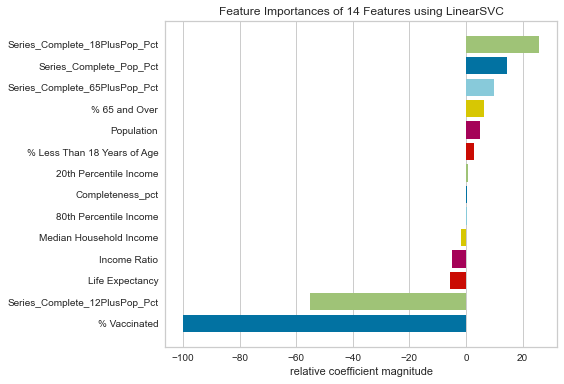

In [163]:
for model in models:
    score_model_test(X, y, model)
    visualize_model_split(X, y, model)
    viz = FeatureImportances(models[0])
    viz.fit(X, y)
    viz.show()

In [164]:
X = df1[[
         '% Vaccinated', 
         '80th Percentile Income', 
         '20th Percentile Income',  
         'Income Ratio', 
         'Life Expectancy', 
         'Median Household Income', 
         'Population', 
         '% Less Than 18 Years of Age', 
         '% 65 and Over',  
         '% Black', 
         '% American Indian & Alaska Native', 
         '% Asian', 
         '% Native Hawaiian/Other Pacific Islander',
         '% Hispanic', 
         '% Non-Hispanic White', 
         '% Female', 
         '% Rural', 
         #'Series_Complete_Pop_Pct', 
         #'Series_Complete_12PlusPop_Pct',
         #'Series_Complete_18PlusPop_Pct',
         #'Series_Complete_65PlusPop_Pct', 
         #'Completeness_pct', 
         
          ]]

y = df1['Dem0_Rep1']

F1 SCORE LinearSVC: 0.9576107899807321
0.9278688524590164


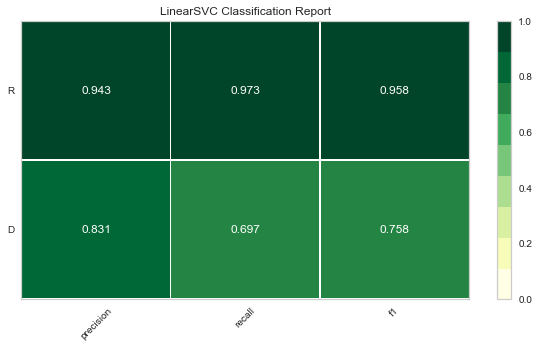

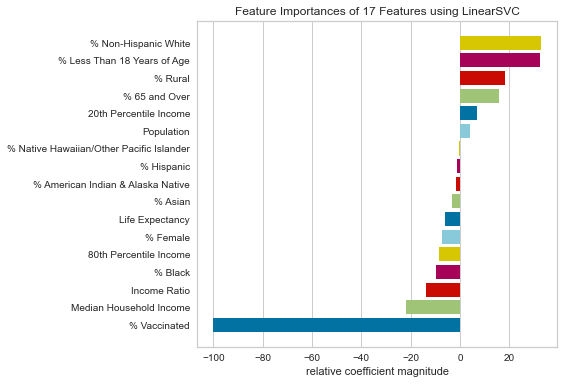

In [165]:
for model in models:
    score_model_test(X, y, model)
    visualize_model_split(X, y, model)
    viz = FeatureImportances(models[0])
    viz.fit(X, y)
    viz.show()

In [166]:
X = df1[[
         '% Vaccinated', #moved down
         '80th Percentile Income', #moved down
         '20th Percentile Income',  #moved down
         'Income Ratio', # moved down
         #'Life Expectancy', # D percision moved up
         'Median Household Income', # moves down when removed
         #'Population', #D recall moves up .01 when removed
         '% Less Than 18 Years of Age', #moved down
         '% 65 and Over',  #moved down
         #'% Black', #D recall stays, percision moves DOWN
         #'% American Indian & Alaska Native', #change negligable, so removed
         #'% Asian', #percision goes DOWN .01 when removed
         #'% Native Hawaiian/Other Pacific Islander', #percision goes up slightly when removed
         '% Hispanic', #d recall moves down when removed
         '% Non-Hispanic White', #moved down
         '% Female', #moved down
         '% Rural', #moved down
         'Series_Complete_Pop_Pct', 
         'Series_Complete_12PlusPop_Pct',
         'Series_Complete_18PlusPop_Pct',
         'Series_Complete_65PlusPop_Pct', 
         #'Completeness_pct', #recall goes up .02 when removed
         
          ]]

y = df1['Dem0_Rep1']

F1 SCORE LinearSVC: 0.9747081712062258
0.9573770491803278


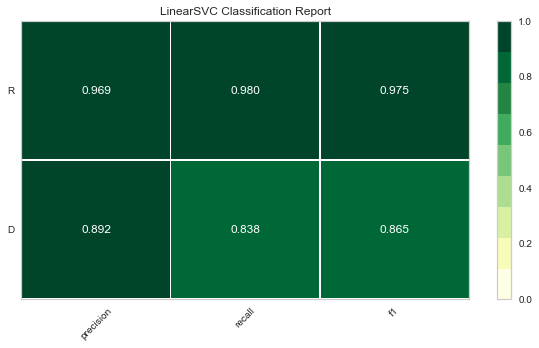

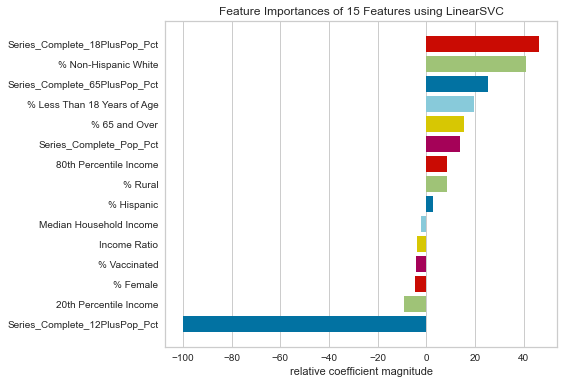

In [167]:
for model in models:
    score_model_test(X, y, model)
    visualize_model_split(X, y, model)
    viz = FeatureImportances(models[0])
    viz.fit(X, y)
    viz.show()

# Final List of Features

In [168]:
X = df1[[
         '% Vaccinated', 
         '80th Percentile Income', 
         '20th Percentile Income',  
         'Income Ratio', 
         'Median Household Income', 
         '% Less Than 18 Years of Age',
         '% 65 and Over',  
         '% Hispanic', 
         '% Non-Hispanic White', 
         '% Female', 
         '% Rural', 
         'Series_Complete_Pop_Pct', 
         'Series_Complete_12PlusPop_Pct',
         'Series_Complete_18PlusPop_Pct',
         'Series_Complete_65PlusPop_Pct', 
          ]]

y = df1['Dem0_Rep1']

F1 SCORE LinearSVC: 0.9747081712062258
0.9573770491803278


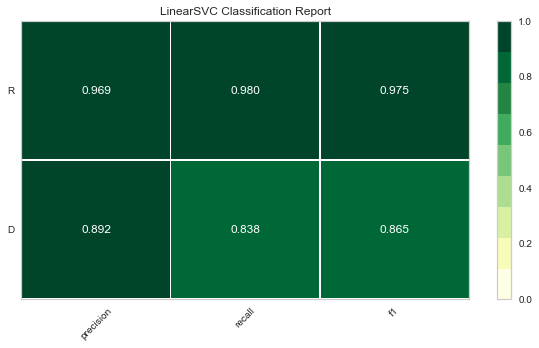

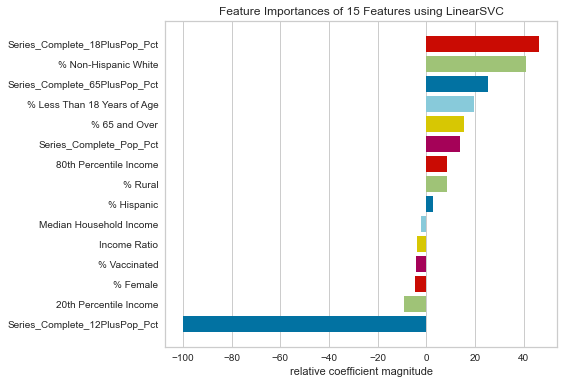

In [169]:
for model in models:
    score_model_test(X, y, model)
    visualize_model_split(X, y, model)
    viz = FeatureImportances(models[0])
    viz.fit(X, y)
    viz.show()

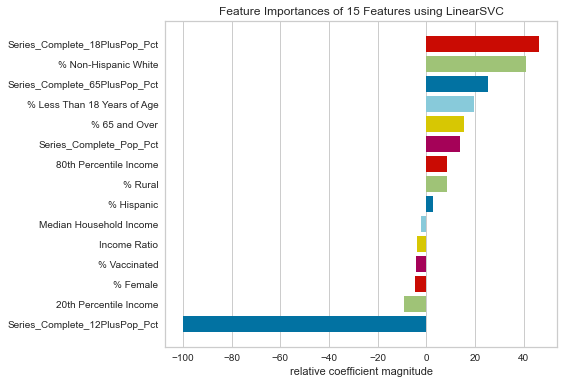

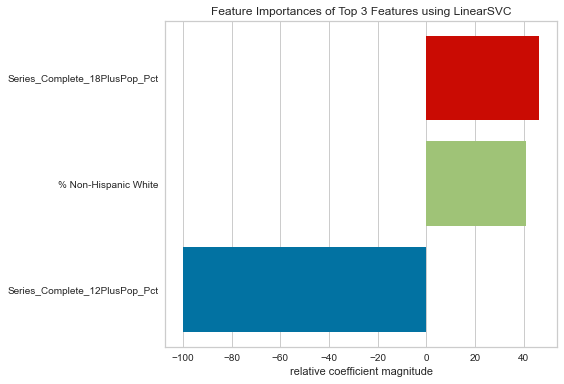

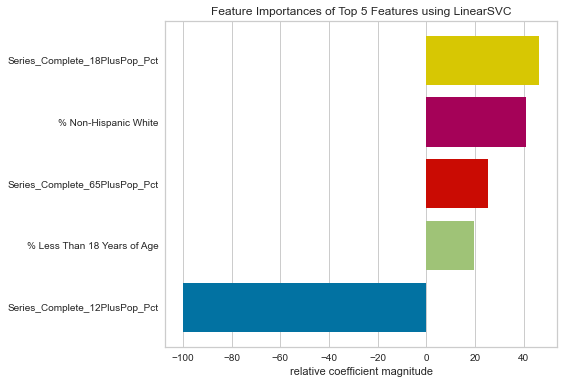


These are the bottom features Below





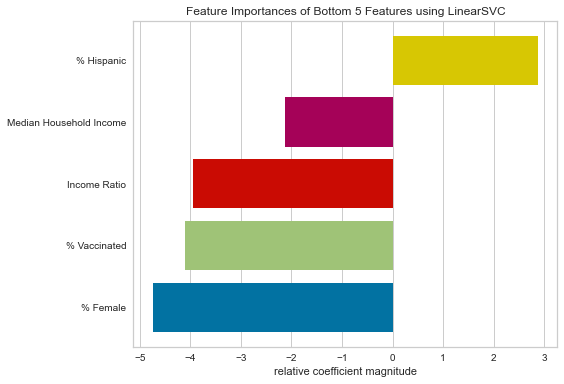

In [170]:
for model in models:
    viz = FeatureImportances(model)
    viz.fit(X, y)
    viz.show()
    viz = FeatureImportances(model, topn=3)
    viz.fit(X, y)
    viz.show()
    viz = FeatureImportances(model, topn=5)
    viz.fit(X, y)
    viz.show()
    print()
    print('These are the bottom features Below')
    print()
    print()
    print()
    viz = FeatureImportances(model, topn=-5)
    viz.fit(X, y)
    viz.show()

Using boilerplait code to confirm, on our limited set of features, that LSVC is still better than rbf

# ***Another Grid Seach Below

In [171]:
from sklearn.metrics import classification_report

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = tts(
    X, y, test_size=0.8, random_state=11)
X = preprocessing.scale(X)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

   

# Tuning hyper-parameters for precision



KeyboardInterrupt: 

In [64]:
# Tuning hyper-parameters for precision

#Best parameters set found on development set:

#{'C': 100, 'kernel': 'linear'}

#Grid scores on development set:

#0.415 (+/-0.004) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
#0.415 (+/-0.004) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
#0.415 (+/-0.004) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
#0.415 (+/-0.004) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
#0.415 (+/-0.004) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
#0.415 (+/-0.004) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
#0.880 (+/-0.110) for {'C': 1, 'kernel': 'linear'}
#0.875 (+/-0.069) for {'C': 10, 'kernel': 'linear'}
#0.883 (+/-0.105) for {'C': 100, 'kernel': 'linear'}

#Detailed classification report:

#The model is trained on the full development set.
#The scores are computed on the full evaluation set.

#              precision    recall  f1-score   support
#
#           0       0.78      0.65      0.71       380
#           1       0.94      0.97      0.95      2059
#
 #   accuracy                           0.92      2439
  # macro avg       0.86      0.81      0.83      2439
#weighted avg       0.91      0.92      0.91      2439


# Tuning hyper-parameters for recall

#Best parameters set found on development set:

#{'C': 10, 'kernel': 'linear'}

#Grid scores on development set:

#0.500 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
#0.500 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
#0.500 (+/-0.000) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
#0.500 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
#0.500 (+/-0.000) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
#0.500 (+/-0.000) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
#0.788 (+/-0.087) for {'C': 1, 'kernel': 'linear'}
#0.810 (+/-0.081) for {'C': 10, 'kernel': 'linear'}
#0.798 (+/-0.084) for {'C': 100, 'kernel': 'linear'}

#Detailed classification report:

#The model is trained on the full development set.
#The scores are computed on the full evaluation set.

#              precision    recall  f1-score   support
#
 #          0       0.79      0.67      0.72       380
  #         1       0.94      0.97      0.95      2059

#    accuracy                           0.92      2439
#   macro avg       0.87      0.82      0.84      2439
#weighted avg       0.92      0.92      0.92      2439

In [181]:
X = df1[[
         '% Vaccinated', 
         '80th Percentile Income', 
         '20th Percentile Income',  
         'Income Ratio', 
         'Median Household Income', 
         '% Less Than 18 Years of Age',
         '% 65 and Over',  
         '% Hispanic', 
         '% Non-Hispanic White', 
         '% Female', 
         '% Rural', 
         'Series_Complete_Pop_Pct', 
         'Series_Complete_12PlusPop_Pct',
         'Series_Complete_18PlusPop_Pct',
         'Series_Complete_65PlusPop_Pct', 
          ]]

y = df1['Dem0_Rep1']

In [182]:
models = [
    SVC(kernel='linear', C=100), ]

F1 SCORE SVC: 0.9728155339805825
0.9540983606557377


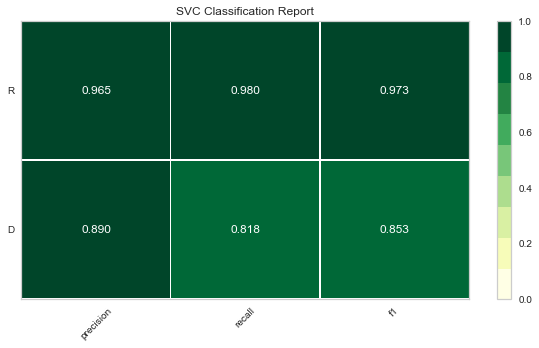

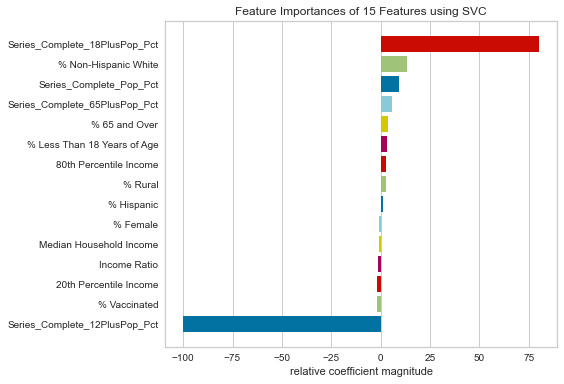

In [183]:
for model in models:
    score_model_test(X, y, model)
    visualize_model_split(X, y, model)
    viz = FeatureImportances(models[0])
    viz.fit(X, y)
    viz.show()

In [184]:
models = [
    SVC(kernel='linear', C=10) ]

F1 SCORE SVC: 0.9718172983479104
0.9524590163934427


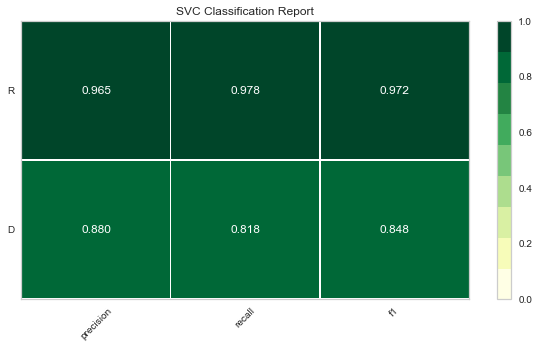

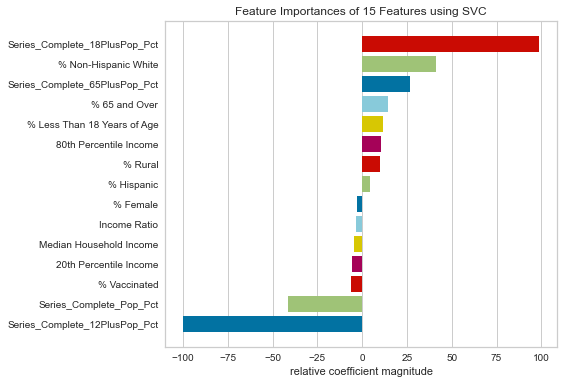

In [185]:
for model in models:
    score_model_test(X, y, model)
    visualize_model_split(X, y, model)
    viz = FeatureImportances(models[0])
    viz.fit(X, y)
    viz.show()

In [186]:
models = [
    LinearSVC(C=1, random_state=41), 
    ]

F1 SCORE LinearSVC: 0.9747081712062258
0.9573770491803278


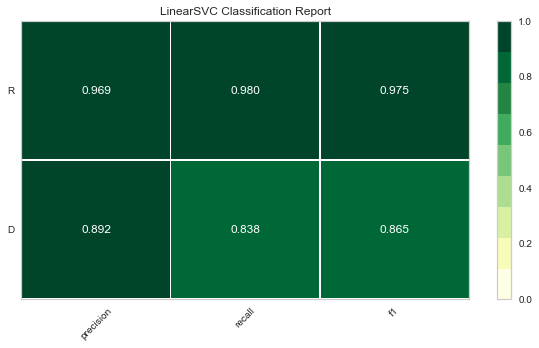

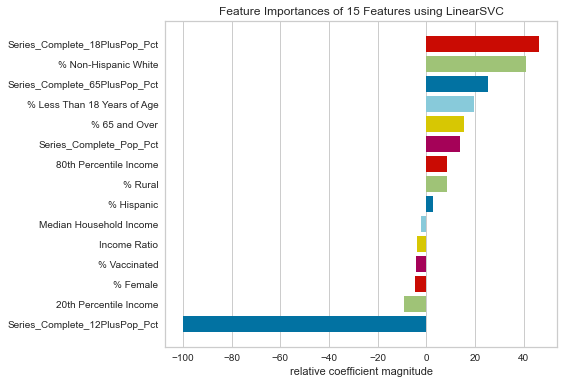

In [187]:
for model in models:
    score_model_test(X, y, model)
    visualize_model_split(X, y, model)
    viz = FeatureImportances(models[0])
    viz.fit(X, y)
    viz.show()

In [188]:
from yellowbrick.classifier import confusion_matrix
def confusion(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', MinMaxScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer, can change for any visualizer in Yellow Brick
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, random_state=11)
    
    visualizer = confusion_matrix(
        model,
        X_train, y_train, X_test, y_test,
        classes=['Dem', 'Rep']
        )
    plt.tight_layout()
    
    
    
    
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.show()  

# Final Results

F1 SCORE LinearSVC: 0.9747081712062258
0.9573770491803278


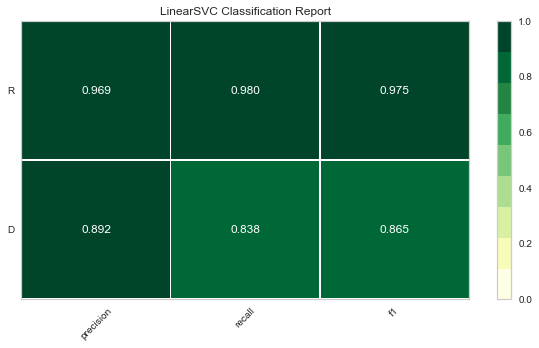

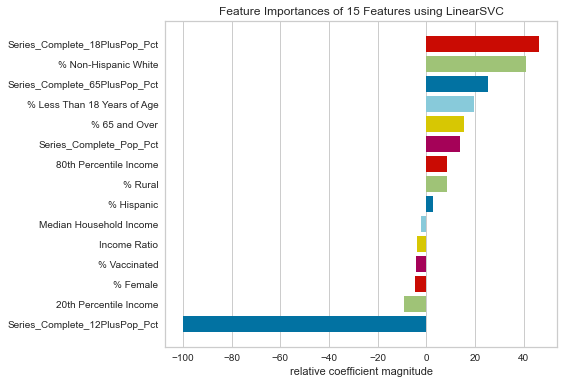

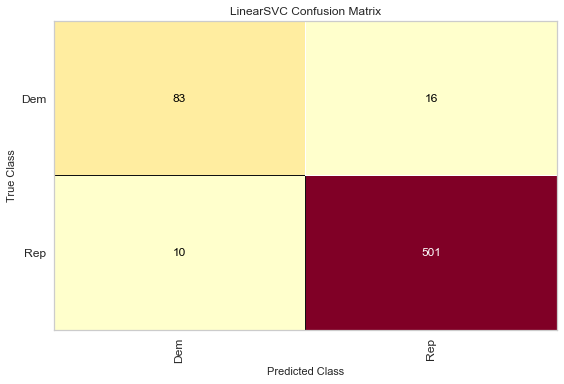

<Figure size 576x396 with 0 Axes>

In [189]:
for model in models:
    score_model_test(X, y, model)
    visualize_model_split(X, y, model)
    viz = FeatureImportances(models[0])
    viz.fit(X, y)
    viz.show()
    confusion(X, y, model)